# Header Files

In [10]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
import string
import re
import joblib
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords 
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2


from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC,SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, make_scorer
from xgboost import XGBClassifier

# Data Import

In [2]:
# import flipkart data into pandas dataframe
Main_df = pd.read_csv('Main_data.csv')

In [3]:
# see types of columns in data
Main_df.dtypes

uniq_id                     object
crawl_timestamp             object
product_url                 object
product_name                object
product_category_tree       object
pid                         object
retail_price               float64
discounted_price           float64
image                       object
is_FK_Advantage_product       bool
description                 object
product_rating              object
overall_rating              object
brand                       object
product_specifications      object
dtype: object

In [4]:
# some examples from data
Main_df.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,c2d766ca982eca8304150849735ffef9,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2FF9KEDEFGF,999.0,379.0,"[""http://img5a.flixcart.com/image/short/u/4/a/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
1,7f7036a6d550aaa89d34c77bd39a5e48,2016-03-25 22:59:23 +0000,http://www.flipkart.com/fabhomedecor-fabric-do...,FabHomeDecor Fabric Double Sofa Bed,"[""Furniture >> Living Room Furniture >> Sofa B...",SBEEH3QGU7MFYJFY,32157.0,22646.0,"[""http://img6a.flixcart.com/image/sofa-bed/j/f...",False,FabHomeDecor Fabric Double Sofa Bed (Finish Co...,No rating available,No rating available,FabHomeDecor,"{""product_specification""=>[{""key""=>""Installati..."
2,f449ec65dcbc041b6ae5e6a32717d01b,2016-03-25 22:59:23 +0000,http://www.flipkart.com/aw-bellies/p/itmeh4grg...,AW Bellies,"[""Footwear >> Women's Footwear >> Ballerinas >...",SHOEH4GRSUBJGZXE,999.0,499.0,"[""http://img5a.flixcart.com/image/shoe/7/z/z/r...",False,Key Features of AW Bellies Sandals Wedges Heel...,No rating available,No rating available,AW,"{""product_specification""=>[{""key""=>""Ideal For""..."
3,0973b37acd0c664e3de26e97e5571454,2016-03-25 22:59:23 +0000,http://www.flipkart.com/alisha-solid-women-s-c...,Alisha Solid Women's Cycling Shorts,"[""Clothing >> Women's Clothing >> Lingerie, Sl...",SRTEH2F6HUZMQ6SJ,699.0,267.0,"[""http://img5a.flixcart.com/image/short/6/2/h/...",False,Key Features of Alisha Solid Women's Cycling S...,No rating available,No rating available,Alisha,"{""product_specification""=>[{""key""=>""Number of ..."
4,bc940ea42ee6bef5ac7cea3fb5cfbee7,2016-03-25 22:59:23 +0000,http://www.flipkart.com/sicons-all-purpose-arn...,Sicons All Purpose Arnica Dog Shampoo,"[""Pet Supplies >> Grooming >> Skin & Coat Care...",PSOEH3ZYDMSYARJ5,220.0,210.0,"[""http://img5a.flixcart.com/image/pet-shampoo/...",False,Specifications of Sicons All Purpose Arnica Do...,No rating available,No rating available,Sicons,"{""product_specification""=>[{""key""=>""Pet Type"",..."


# Preprocessing

In [5]:
#-------------------------------------------------------------------------#
# search of sentance which is other than string and then delete them
for num in range(Main_df.shape[0]):
    if type(Main_df.loc[num, 'description'])!=str:
        print(num," : ",Main_df.loc[num, 'description'])
        

Main_df = Main_df[Main_df['description'].notna()]

553  :  nan
17299  :  nan


In [6]:
#-------------------------------------------------------------------------#
# convert all sentance to lowercase
Main_df['description'] = Main_df['description'].apply(lambda x: x.lower())

#-------------------------------------------------------------------------#
# tokenize sentance with condition
# 1. only word with character
# 2. word size is more than 3
tokenizer = RegexpTokenizer(r'([a-z]{4,})\W' , gaps = False)
Main_df['description'] = Main_df['description'].apply(lambda x: tokenizer.tokenize(x))

#-------------------------------------------------------------------------#
# remove stop words
stop_words = set(stopwords.words('english')) 
Main_df['description'] = Main_df['description'].apply(lambda x: [w for w in x if not w in stop_words])

#-------------------------------------------------------------------------#
# lemmatize the words
lemmatizer = WordNetLemmatizer()
Main_df['description'] = Main_df['description'].apply(lambda x: [lemmatizer.lemmatize(w) for w in x])

#-------------------------------------------------------------------------#
# join words to create sentance
Main_df['description'] = Main_df['description'].apply(lambda x: " ".join(x))

# Label Preprocessing

In [7]:
#-------------------------------------------------------------------------#
# convert all sentance to lowercase
Main_df['product_category_tree'] = Main_df['product_category_tree'].apply(lambda x: x.lower())

#-------------------------------------------------------------------------#
# spilt category tree to get primary category
Main_df['category'] = Main_df['product_category_tree'].apply(lambda x: x.split(">>")[0])


#-------------------------------------------------------------------------#
# filter unnessary words from category
pattern = re.compile('[\W_]+')
Main_df['category'] = Main_df['category'].apply(lambda x: pattern.sub(" ", x))
Main_df['category'] = Main_df['category'].apply(lambda x: x[1:-1])

In [8]:
#-------------------------------------------------------------------------#
# There are total 256 category but only top 50 are visualised
print("Total unique category : ", Main_df['category'].unique().shape[0])
print("All category frequency")
Main_df['category'].value_counts().head(50).to_frame().style.bar()

Total unique category :  265
All category frequency


,category
clothing,6197
jewellery,3531
footwear,1227
mobiles accessories,1099
automotive,1012
home decor festive needs,929
beauty and personal care,710
home furnishing,699
kitchen dining,647
computers,578


In [9]:
#-------------------------------------------------------------------------#
# taken only those category which has frequency of more than 50
Category_count = Main_df['category'].value_counts()
Category_count = Category_count[Category_count>50]
Category_taken = Category_count.index.to_list()
Main_df = Main_df[Main_df['category'].isin(Category_taken)]

#-------------------------------------------------------------------------#
# convert string category to number category
Category_Mapping = {}
for (index, category) in enumerate(Category_taken):
    Category_Mapping[category] = index+1
Main_df['category'] = Main_df['category'].apply(lambda x: Category_Mapping[x])

In [10]:
#-------------------------------------------------------------------------#
# There are the frequency of selected category
print("Selected category frequency")
Main_df['category'].value_counts().to_frame().style.bar()

Selected category frequency


,category
1,6197
2,3531
3,1227
4,1099
5,1012
6,929
7,710
8,699
9,647
10,578


In [11]:
#-------------------------------------------------------------------------#
# Category mapping dictionary
print("Category are mapped as below")
Category_Mapping

Category are mapped as below


{'clothing': 1,
 'jewellery': 2,
 'footwear': 3,
 'mobiles accessories': 4,
 'automotive': 5,
 'home decor festive needs': 6,
 'beauty and personal care': 7,
 'home furnishing': 8,
 'kitchen dining': 9,
 'computers': 10,
 'watches': 11,
 'baby care': 12,
 'tools hardware': 13,
 'toys school supplies': 14,
 'pens stationery': 15,
 'bags wallets belts': 16,
 'furniture': 17,
 'sports fitness': 18,
 'cameras accessories': 19,
 'home improvement': 20}

# Data split

In [12]:
#-------------------------------------------------------------------------#
# Shuffle rows of pandas dataframe
Main_df = Main_df.sample(frac=1).reset_index(drop=True)

#-------------------------------------------------------------------------#
# Select labels and features
X = Main_df['description']
Y = Main_df['category']

# Cross validation of default model

In [13]:
#-------------------------------------------------------------------------#
# Parameter 
#          model = model class from sklearn or xgboost library
#              X = Pandas series of one column of processed sentance (in str form) 
#              Y = Pandas series of one column of related category (in numeric form)
#
#
# This function will take processed sentance and category label, 
# Tf Idf of training data will be extracted 
# from extracted features only 8000 features will be taken out on the basis on chi
# selected features will be trained on model passed from parameter
#
# Above step will be done 5 time and scores will be calculated and stored returned
#
# accuracy, precision, recal, F1, MCC score of every fold will be recored
#
#
# Return 
#      cv_result = scores from cross validation
#-------------------------------------------------------------------------#

def Cross_validate_model(model, X, y):

    scoring = {'accuracy': 'accuracy', 
                'precision_weighted':'precision_weighted', 
                'recall_weighted':'recall_weighted', 
                'f1_weighted':'f1_weighted', 
                'matthews_corrcoef': make_scorer(matthews_corrcoef)}

    tfidf_vectorizer = TfidfVectorizer(lowercase=False, 
                                         preprocessor=None, 
                                         tokenizer=None,
                                         ngram_range=(1,2),
                                         binary=False)

    feature_selector = SelectKBest(chi2, k=8000)

    pipeline = Pipeline([('tfidf', tfidf_vectorizer),
                         ('feature_selection',  feature_selector),
                         ('model', model)])
    
    kfold = KFold(n_splits=5, shuffle=True, random_state=100)

    cv_results = cross_validate(pipeline, X, y, cv=kfold, scoring=scoring)
    
    return cv_results    

#-------------------------------------------------------------------------#
# Parameter 
#      mat_list = dictionary in which key is name of model and value is cross validation score from function Cross_Validation
#
#
# This function will combine cross validation score from dictionary and creates a pandas dataframe
# from the pandas dataframe created boxplot of every score from cross validation score matix will be shown in which 
# on X axis = Model name
# on Y axis = Score 
#
#
# Return 
#      None
#-------------------------------------------------------------------------#

def graphs_matrice(mat_list):
    
    mat_df = []
    for key, value in mat_list:
        this_df = pd.DataFrame(value)
        this_df['model'] = key
        mat_df.append(this_df)
        
    final_df = pd.concat(mat_df, ignore_index=True)
            
    grouping = final_df.groupby(by='model', axis=0, as_index=True, sort=False)

    matrices = ['fit_time', 'test_accuracy', 'test_precision_weighted',
            'test_recall_weighted', 'test_f1_weighted',
            'test_matthews_corrcoef']
    
    sns.set(font_scale=1)
    
    for mat in matrices:
        ax = sns.boxplot(x="model", y=mat, hue="model", data=final_df, palette="Set3")
        ax.get_legend().remove()
        plt.show()

In [61]:
#-------------------------------------------------------------------------#
# Record cross validation score of logistic regression model
Logistic_regression = Cross_validate_model(LogisticRegression(), X, Y)

E:\Anaconda\envs\groel\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
E:\Anaconda\envs\groel\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regress

In [51]:
#-------------------------------------------------------------------------#
# Record cross validation score of random forest model
Random_forest = Cross_validate_model(RandomForestClassifier(), X, Y)

In [66]:
#-------------------------------------------------------------------------#
# Record cross validation score of XGBboost model
XGBRandom_forest = Cross_validate_model(XGBClassifier(), X, Y)

In [37]:
#-------------------------------------------------------------------------#
# Record cross validation score of KNN model
KNearest_Neighbour  = Cross_validate_model(KNeighborsClassifier(), X, Y)

In [59]:
#-------------------------------------------------------------------------#
# Record cross validation score of SVC model
Support_Vector_Classifier = Cross_validate_model(SVC(), X, Y)

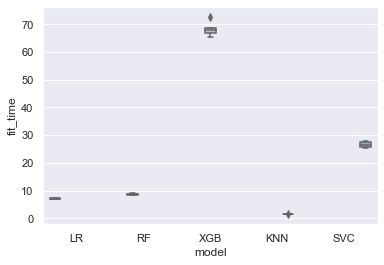

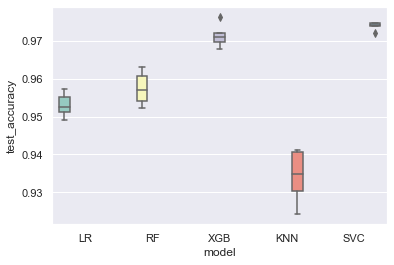

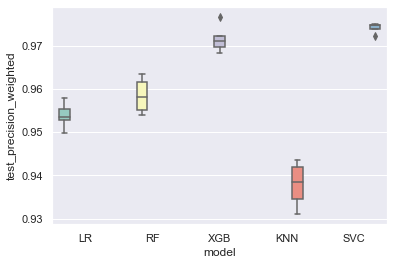

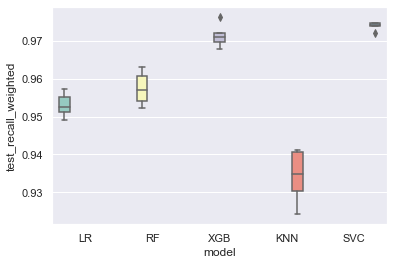

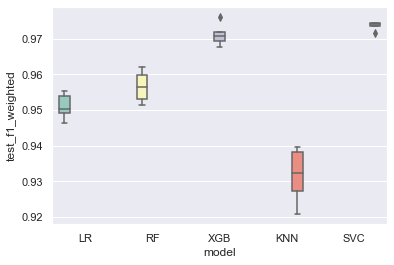

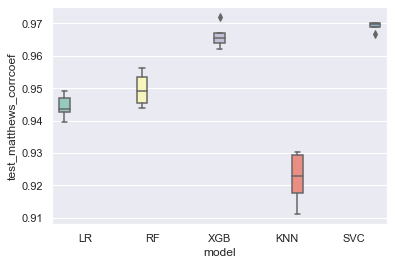

In [68]:
#-------------------------------------------------------------------------#
# Show box plot for cross validation score recorded above
graphs_matrice([('LR', Logistic_regression), 
                ('RF', Random_forest), 
                ('XGB', XGBRandom_forest), 
                ('KNN', KNearest_Neighbour), 
                ('SVC', Support_Vector_Classifier)])

# Save best model

In [13]:
#-------------------------------------------------------------------------#
# Parameter 
#             X = Pandas series of one column of processed sentance (in str form) 
#             Y = Pandas series of one column of related category (in numeric form)
#
#
# This function will create train and test data of processed data 
# train data will be used to model in which tf idf and top 8000 feature selection on the basis of chi will be trained
# test data will be prediction of model trained on training data
#
#
# Return 
#    X_train_P = pandas dataframe of top 8000 features from tf idf
#     X_test_P = pandas dataframe of top 8000 features from tf idf
#      y_train = pandas dataframe of category of respective data
#       y_test = pandas dataframe of category of respective data
#      
#-------------------------------------------------------------------------#
def processed_pandas(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=11, stratify=Y)
    X_train, X_test, y_train, y_test = X_train.reset_index(drop=True), X_test.reset_index(drop=True), y_train.reset_index(drop=True), y_test.reset_index(drop=True)

    tfidf_vectorizer = TfidfVectorizer(lowercase=False, 
                                 preprocessor=None, 
                                 tokenizer=None,
                                 ngram_range=(1,2),
                                 binary=False)


    pipeline = Pipeline([('tfidf', tfidf_vectorizer),
                         ('feature_selection',  SelectKBest(chi2, k=8000))])

    model = pipeline.fit(X_train, y_train)

    all_features = model.named_steps['tfidf'].get_feature_names()
    selected_feature_index = model.named_steps['feature_selection'].get_support(indices=True)

    selected_feature_name = [all_features[i] for i in selected_feature_index]

    X_train_P = pd.DataFrame(data = model.transform(X_train).toarray(),columns = selected_feature_name)
    X_test_P  = pd.DataFrame(data = model.transform(X_test).toarray(), columns = selected_feature_name)
    
    return X_train_P, X_test_P, y_train, y_test

In [14]:
#-------------------------------------------------------------------------#
# Get processed train and test data from whole data
X_train, X_test, y_train, y_test = processed_pandas(X, Y)

In [16]:
#-------------------------------------------------------------------------#
# Train and analysis scores of SVC model 
model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("MCC : ",matthews_corrcoef(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.98      0.99      0.99      1239
           2       1.00      0.99      1.00       706
           3       1.00      0.99      0.99       245
           4       0.98      0.97      0.97       220
           5       0.96      0.99      0.97       202
           6       0.93      0.98      0.96       186
           7       0.95      0.95      0.95       142
           8       0.96      0.96      0.96       140
           9       0.94      0.97      0.95       129
          10       0.86      0.93      0.90       116
          11       1.00      0.98      0.99       106
          12       0.90      0.84      0.87        97
          13       1.00      0.95      0.97        78
          14       0.86      0.94      0.90        66
          15       0.96      0.73      0.83        63
          16       0.98      0.87      0.92        53
          17       0.95      0.97      0.96        36
          18       0.97    

In [17]:
#-------------------------------------------------------------------------#
# Save or load SVC model

SVC_model_name = 'SVC_model.sav'
# joblib.dump(model, SVC_model_name)
SVC_model = joblib.load(SVC_model_name)

['SVC_model.sav']

In [15]:
#-------------------------------------------------------------------------#
# Train and analysis scores of XGB model 

model = XGBClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("MCC : ",matthews_corrcoef(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.97      1.00      0.98      1239
           2       1.00      0.99      0.99       706
           3       0.99      0.95      0.97       245
           4       0.96      0.99      0.97       220
           5       0.93      0.97      0.95       202
           6       0.94      0.99      0.96       186
           7       0.99      0.96      0.97       142
           8       0.94      0.95      0.95       140
           9       0.91      0.94      0.92       129
          10       0.79      0.91      0.85       116
          11       1.00      0.99      1.00       106
          12       0.97      0.68      0.80        97
          13       1.00      0.88      0.94        78
          14       0.88      0.85      0.86        66
          15       0.91      0.76      0.83        63
          16       0.98      0.75      0.85        53
          17       0.83      0.94      0.88        36
          18       0.97    

In [16]:
#-------------------------------------------------------------------------#
# Save or load XGB model

XGB_model_name = 'XGB_model.sav'
# joblib.dump(model, XGB_model_name)
XGB_model = joblib.load(XGB_model_name)

['XGB_model.sav']

# Extra code

In [ ]:
# grid search was applied on SVC but due to constrained
param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf']} 
  
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3, scoring = make_scorer(matthews_corrcoef))
  
grid.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.838, total=25.4min
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 25.4min remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.840, total=83.5min
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 108.9min remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.837, total=25.4min
[CV] C=0.1, gamma=1, kernel=rbf ......................................


In [16]:
from lazypredict.Supervised import LazyClassifier

E:\Anaconda\envs\groel\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None, predictions=True)
models, predictions = clf.fit(X_train, X_test, y_train, y_test)

 10%|████████▌                                                                          | 3/29 [04:14<29:34, 68.25s/it]